# **Initial Data Exploration - CMSC320 Project Milestone 2**

Requirements are listed [here](https://acrobat.adobe.com/link/review?uri=urn%3Aaaid%3Ascds%3AUS%3A1a28f442-fc75-341a-990f-af6d7aec3950).

# Preprocessing

The first thing we need to do is preprocess the data.

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
df= pd.read_csv("data/netflix-rotten-tomatoes-metacritic-imdb.csv")

In [4]:
print(df.columns)

Index(['Title', 'Genre', 'Tags', 'Languages', 'Series or Movie',
       'Hidden Gem Score', 'Country Availability', 'Runtime', 'Director',
       'Writer', 'Actors', 'View Rating', 'IMDb Score',
       'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received',
       'Awards Nominated For', 'Boxoffice', 'Release Date',
       'Netflix Release Date', 'Production House', 'Netflix Link', 'IMDb Link',
       'Summary', 'IMDb Votes', 'Image', 'Poster', 'TMDb Trailer',
       'Trailer Site'],
      dtype='object')


Here are the percentages of each column which are NaN.

This could be an issue, many of these columns are probably basically unusable.

In [5]:
df.isna().sum() / df.shape[0]

Title                    0.000000
Genre                    0.110465
Tags                     0.004328
Languages                0.126227
Series or Movie          0.000000
Hidden Gem Score         0.135724
Country Availability     0.001227
Runtime                  0.000065
Director                 0.304134
Writer                   0.279716
Actors                   0.124354
View Rating              0.453747
IMDb Score               0.135594
Rotten Tomatoes Score    0.587726
Metacritic Score         0.719897
Awards Received          0.607558
Awards Nominated For     0.505103
Boxoffice                0.741150
Release Date             0.136111
Netflix Release Date     0.000000
Production House         0.667377
Netflix Link             0.000000
IMDb Link                0.148773
Summary                  0.000581
IMDb Votes               0.135724
Image                    0.000000
Poster                   0.235013
TMDb Trailer             0.535271
Trailer Site             0.535271
dtype: float64

## Cleaning up tags

Several of the columns (listed below) are comma-separated lists.

We convert them to Python lists to be easier to parse.


In [6]:
# Convert comma separated fields to lists
cols_to_clean= ['Genre', 'Tags', 'Languages', 'Country Availability', 'Director', 'Writer', 'Actors', 'Production House']
for col in cols_to_clean:
  df[col]= df[col].dropna().map(lambda x: x.split(','))

In [8]:
print(df['Tags'])

0        [Comedy Programmes, Romantic TV Comedies, Horr...
1        [Dramas, Comedies, Films Based on Books, British]
2                                              [Thrillers]
3          [TV Dramas, Romantic TV Dramas, Dutch TV Shows]
4        [Social Issue Dramas, Teen Movies, Dramas, Com...
                               ...                        
15475    [TV Dramas, TV Programmes, TV Comedies, Romant...
15476    [Animal Tales, Family Comedies, Family Adventu...
15477    [TV Comedies, Kids TV, Animal Tales, TV Cartoo...
15478    [TV Comedies, Kids TV, TV Cartoons, TV Program...
15479    [TV Comedies, Kids TV, Animal Tales, TV Cartoo...
Name: Tags, Length: 15480, dtype: object


In [7]:
# find all unique tags
unique_tags= {}
for x in df['Tags'].dropna():
  for tag in x:
    if tag in unique_tags:
      unique_tags[tag] += 1
    else:
      unique_tags[tag]= 1

tags= pd.Series(unique_tags).sort_values(ascending=False)
tags
# tags

Dramas                      4558
Comedies                    4168
Action & Adventure          2094
TV Dramas                   1207
International Movies        1198
                            ... 
Educación y orientación        1
TV para niños                  1
Historias de animales          1
Dibujos animados               1
Programas de TV y series       1
Length: 1003, dtype: int64

In [8]:
# find all unique tags
uniques= {}
tags= {}
for col in ['Tags', 'Genre', 'Director', 'Actors']:
  uniques[col]= {}
  for x in df[col].dropna():
    for tag in x:
      if tag in uniques[col]:
        uniques[col][tag] += 1
      else:
        uniques[col][tag]= 1

  uniques[col]= pd.Series(uniques[col]).sort_values(ascending=False)

We can probably collapse the least popular tags into some kind of `Other`.

There are around 1300 tags with fewer than 10 instances in the database, combining these into `Other` would be one of our more common tags, not sure if this is acceptable.

In [9]:
print(uniques['Tags'][uniques['Tags'] < 10].sum())
print(len(uniques['Tags'][uniques['Tags'] < 10]))

1312
344


There are a lot of different tags, this data is super high-dimensional.

In [10]:
len(uniques['Tags'])

1003

The `Genre` column seems less awful, we should be able to use this as is.

In [11]:
uniques['Genre'][uniques['Genre'] < 10].sum()

np.int64(17)

## Cleaning Box Office Figures

The `BoxOffice` column has dollar amounts formatted in a disgusting way.
These will need to be parsed

In [13]:
import re
dollar_re= re.compile(r'^\$([0-9,.]+)$')

def num_of_money(string):
  '''
  Converts a string with a dollar amount into a float
  '''
  matched= dollar_re.match(string)
  if matched:
    money= matched.group(1)
    money= money.replace(',', '') # delete all the commas (there are commas for some reason?)
    money= int(money)
    return money

In [14]:
df['Boxoffice']= df['Boxoffice'].dropna().apply(num_of_money)

In [15]:
df['Boxoffice']

0        2122065.0
1          70632.0
2          16263.0
3              NaN
4              NaN
           ...    
15475          NaN
15476          NaN
15477          NaN
15478          NaN
15479          NaN
Name: Boxoffice, Length: 15480, dtype: float64

# Hypothesis Testing


1) Let's apply an ANOVA test on the IMDb Score of the 3 most popular types of movies to test if the genre affects it

$H_0$: The genre of the movie does not affect the IMDb Score

$H_a$: The genre of the movie affect the IMDb Score

In [16]:
# Getting the top 3 genre of movies
popular_genre = df['Genre'].value_counts()
print(popular_genre.head(3))

Genre
[Comedy]         1186
[Drama]          1013
[Documentary]     460
Name: count, dtype: int64


The top 3 genre of movies are Comedy, Drama, and Documentary

Let's apply an ANOVA test on these 3 genre of movies

In [23]:
from scipy.stats import f_oneway

# Getting the IMDb Score of the 3 different genre of movies
comedy_score = df[df['Genre'].apply(lambda genres: isinstance(genres, list) and genres == ['Comedy'])]['IMDb Score']
drama_score = df[df['Genre'].apply(lambda genres: isinstance(genres, list) and genres == ['Drama'])]['IMDb Score']
documentary_score = df[df['Genre'].apply(lambda genres: isinstance(genres, list) and genres == ['Documentary'])]['IMDb Score']

# Applying ANOVA test
f_statistic, p_value = f_oneway(comedy_score.dropna(), drama_score.dropna(), documentary_score.dropna())

# Printing the p_value
print("P-Value: ", p_value)

P-Value:  3.2669512164418477e-59


In conclusion, because the p_value is less than the significance level of 0.05, we fail to reject the null hypothesis. As a result, the genre does not have any effect on the IMDb score of the movie. 

Let's generate a plot, illustrating this conclusion

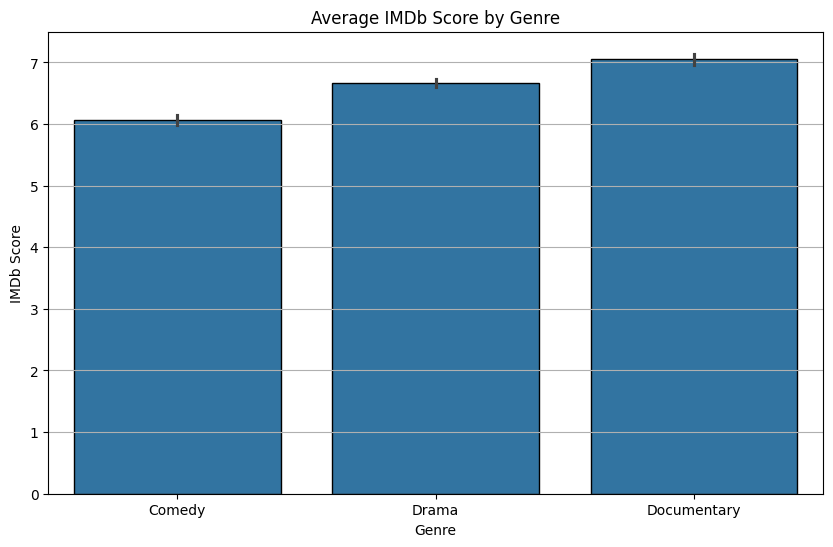

In [29]:
import matplotlib.pyplot as plt

# Defining a dataframe for the display
score_df = pd.DataFrame({
    'Genre': ['Comedy'] * len(comedy_score) + ['Drama'] * len(drama_score) + ['Documentary'] * len(documentary_score),
    'IMDb Score': list(comedy_score) + list(drama_score) + list(documentary_score)
})

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='IMDb Score', data=score_df, edgecolor='black')
plt.title('Average IMDb Score by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDb Score')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Displaying the plot
plt.show()

##

# Other

Some additional information for later use:
[This](https://datascience.stackexchange.com/questions/85488/encoding-tags-for-random-forest) seems relevant.

After that we will need to reduce the dimensionality, perhaps with [this](https://medium.com/codex/dimensionality-reduction-techniques-for-categorical-continuous-data-75d2bca53100).